In [465]:
from pysal.contrib.spint.gravity import  BaseGravity, Gravity, Production, Attraction, Doubly
from pysal.contrib.spint.dispersion import phi_disp
from pysal.contrib.spint.vec_SA import VecMoran
import pysal as ps
import pandas as pd
import geopandas as gp
import numpy as np
import seaborn as sb
import matplotlib.pylab as plt
%pylab inline
from descartes import PolygonPatch
import matplotlib as mpl
from mpl_toolkits.basemap import Basemap
import pyproj as pj
from shapely.geometry import Polygon, Point

Populating the interactive namespace from numpy and matplotlib


//anaconda/envs/spint/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['plt', 'Polygon']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [466]:
#Load NYC bike data - trips between census tract centroids
bikes = pd.read_csv(ps.examples.get_path('nyc_bikes_ct.csv'))
bikes.head()

,Unnamed: 0,index,count,d_cap,d_tract,distance,end station latitude,end station longitude,o_cap,o_tract,...,weighted,total_out,total_in,o_hub,d_hub,od_hub,SX,SY,EX,EY
0,0,0,5709,255.0,600,NaN,40.712899,-73.989865,162.0,202,...,0.0,56352,69165,hub,hub,hub,585995.353038,4.507417e+06,585322.159723,4.507378e+06
1,1,1,4010,595.0,600,NaN,40.712899,-73.989865,774.0,700,...,0.0,160040,69165,hub,hub,hub,583785.918305,4.506573e+06,585322.159723,4.507378e+06
2,2,2,1906,170.0,600,NaN,40.712899,-73.989865,141.0,800,...,0.0,34254,69165,hub,hub,non_hub,585018.109713,4.507320e+06,585322.159723,4.507378e+06
3,3,3,1192,255.0,600,NaN,40.712899,-73.989865,291.0,900,...,0.0,46446,69165,hub,hub,non_hub,583444.520998,4.506199e+06,585322.159723,4.507378e+06
4,4,4,484,85.0,600,NaN,40.712899,-73.989865,57.0,1002,...,0.0,15916,69165,hub,hub,non_hub,586462.456350,4.507937e+06,585322.159723,4.507378e+06


In [467]:
#Process data

#Remove intrazonal flows
bikes = bikes[bikes['o_tract'] != bikes['d_tract']]

#Set zero attirbute values to a small constant
bikes.ix[bikes.o_sq_foot == 0, 'o_sq_foot'] = 1
bikes.ix[bikes.d_sq_foot == 0, 'd_sq_foot'] = 1
bikes.ix[bikes.o_cap == 0, 'o_cap'] = 1
bikes.ix[bikes.d_cap == 0, 'd_cap'] = 1
bikes.ix[bikes.o_housing == 0, 'o_housing'] = 1
bikes.ix[bikes.d_housing == 0, 'd_housing'] = 1

#Flows between tracts
flows = bikes['count'].values.reshape((-1,1))

#Origin variables: square footage of buildings, housing units, total station capacity
o_vars = np.hstack([bikes['o_sq_foot'].values.reshape((-1,1)),
                    bikes['o_housing'].values.reshape((-1,1)),
                    bikes['o_cap'].values.reshape((-1,1))])

#Destination variables: square footage of buildings, housing units, total station capacity
d_vars = np.hstack([bikes['d_sq_foot'].values.reshape((-1,1)),
                    bikes['d_housing'].values.reshape((-1,1)),
                    bikes['d_cap'].values.reshape((-1,1))])

#Trip "cost" in time (seconds)
cost = bikes['tripduration'].values.reshape((-1,1))

#Origin ids
o = bikes['o_tract'].astype(str).values.reshape((-1,1))

#destination ids
d = bikes['d_tract'].astype(str).values.reshape((-1,1))

print len(bikes), ' OD pairs between census tracts after filtering out intrazonal flows'

14042  OD pairs between census tracts after filtering out intrazonal flows


In [468]:
#First we fit a basic gravity model and examine the parameters and model fit

grav= Gravity(flows, o_vars, d_vars, cost, 'exp')

print grav.params

print 'Adjusted psuedo R2: ', grav.adj_pseudoR2
print 'Adjusted D2: ', grav.adj_D2
print 'SRMSE: ', grav.SRMSE
print 'Sorensen similarity index: ', grav.SSI

[ 0.09898099  0.05748786  0.50319944  0.06920194  0.06408526  0.39371417
 -0.00226671]
Adjusted psuedo R2:  0.772607968896
Adjusted D2:  0.77684235847
SRMSE:  0.924994119459
Sorensen similarity index:  0.746131903798


In [5]:
#Next we fit a production-constrained model

prod = Production(flows, o, d_vars, cost, 'exp')

print prod.params[-4:] #truncate to exclude balancing factors/fixed effects

print 'Adjusted psuedo R2: ', prod.adj_pseudoR2
print 'Adjusted D2: ', prod.adj_D2
print 'SRMSE: ', prod.SRMSE
print 'Sorensen similarity index: ', prod.SSI

[ 0.00437122  0.06794379  0.85720958 -0.00227555]
Adjusted psuedo R2:  0.832399632692
Adjusted D2:  0.836963213893
SRMSE:  0.794147843751
Sorensen similarity index:  0.777965361121


In [6]:
#Next we fit an attraction-constrained model

att = Attraction(flows, d, o_vars, cost, 'exp')

print att.params[-4:] #truncate to exclude balancing factors/fixed effects

print 'Adjusted psuedo R2: ', att.adj_pseudoR2
print 'Adjusted D2: ', att.adj_D2
print 'SRMSE: ', att.SRMSE
print 'Sorensen similarity index: ', att.SSI

[ 0.05281568  0.05689814  0.85161213 -0.00229343]
Adjusted psuedo R2:  0.83252844463
Adjusted D2:  0.83709408585
SRMSE:  0.792604389867
Sorensen similarity index:  0.777557481635


In [7]:
#Finally, we fit the doubly constrained model

doub = Doubly(flows, o, d, cost, 'exp')

print doub.params[-1:] #truncate to exclude balancing factors/fixed effects

print 'Adjusted psuedo R2: ', doub.adj_pseudoR2
print 'Adjusted D2: ', doub.adj_D2
print 'SRMSE: ', doub.SRMSE
print 'Sorensen similarity index: ', doub.SSI

[-0.00232112]
Adjusted psuedo R2:  0.895575966583
Adjusted D2:  0.900342219279
SRMSE:  0.627981455879
Sorensen similarity index:  0.818294076455


In [8]:
#Next, we can test the models for violations of the equidispersion assumption of Poisson models

#test the hypotehsis of equidispersion (var[mu] = mu) against that of QuasiPoisson (var[mu] = phi * mu)
#Results = [phi, tvalue, pvalue]
print phi_disp(grav)
print phi_disp(prod)
print phi_disp(att)
print phi_disp(doub)

#We can see for all four models there is overdispersion (phi >> 0), 
#which are statistically significant according the tvalues (large)
#and pvalues (essentially zero). It does however decrease as more 
#constraints are introduced and model fit increases

[  2.99777896e+002   2.38580701e+001   4.17517731e-126]
[  2.06092255e+002   2.60328203e+001   1.05289599e-149]
[  2.07645243e+002   2.64229678e+001   3.73180682e-154]
[  1.18261248e+002   2.96580921e+001   1.33362721e-193]


In [9]:
#As a result we can compare our standard errors and tvalues for a Poisson model to a QuasiPoisson

print 'Production-constrained Poisson model standard errors and tvalues'
print prod.params[-4:]
print prod.std_err[-4:]
print prod.tvalues[-4:]

#Fit the same model using QuasiPoisson framework
Quasi = Production(flows, o, d_vars, cost, 'exp', Quasi=True)

print 'Production-constrained QuasiPoisson model standard errors and tvalues'
print Quasi.params[-4:]
print Quasi.std_err[-4:]
print Quasi.tvalues[-4:]

#As we can see both models result in the same parameters (first line)
#We also see the QuasiPoisson results in larger standard errors (middle line)
#Which then results in smaller t-values (bottom line)
#We would even consdier rejecting the statistical significant of of the 
#parameter estimate on destination building square footage because its abolsute 
# value is less than 1.96 (96% confidence level) 

Production-constrained Poisson model standard errors and tvalues
[ 0.00437122  0.06794379  0.85720958 -0.00227555]
[  5.00039382e-04   3.52444295e-04   6.85493176e-04   1.00141356e-06]
[    8.74174692   192.77880405  1250.5005361  -2272.33530432]
Production-constrained QuasiPoisson model standard errors and tvalues
[ 0.00437122  0.06794379  0.85720958 -0.00227555]
[  7.21095039e-03   5.08251633e-03   9.88533597e-03   1.44411496e-05]
[   0.60619162   13.36813995   86.71527071 -157.57383972]


In [10]:
#We can also estimate a local model which subsets the data
#For a production constrained model this means each local model
#is from one origin to all destinations. Since we get a set of 
#parameter estimates for each origin, we can then map them.

local_prod = prod.local()

In [11]:
#There is a set of local parameter estimates, tvalues, and pvalues for each covariate
#And there is a set of local values for each diagnostic

local_prod.keys()

['pvalue3',
 'pvalue2',
 'SRMSE',
 'pvalue0',
 'deviance',
 'adj_pseudoR2',
 'pvalue1',
 'tvalue0',
 'tvalue2',
 'tvalue3',
 'adj_D2',
 'tvalue1',
 'SSI',
 'aic',
 'param1',
 'param0',
 'param3',
 'D2',
 'pseudoR2',
 'param2']

In [12]:
#Prep geometry for plotting

#Read in census tracts for NYC
crs = {'datum':'WGS84', 'proj':'longlat'}
tracts = ps.examples.get_path('nyct2010.shp')
tracts = gp.read_file(tracts)
tracts = tracts.to_crs(crs=crs)

#subset manhattan tracts
man_tracts = tracts[tracts['BoroCode'] == '1'].copy()
man_tracts['CT2010S'] = man_tracts['CT2010'].astype(int).astype(str)

#Get tracts for which there are no onbservations
mt = set(man_tracts.CT2010S.unique())
lt = set(np.unique(o))
nt = list(mt.difference(lt))
no_tracts = pd.DataFrame({'no_tract':nt})
no_tracts = man_tracts[man_tracts.CT2010S.isin(nt)].copy()

#Join local values to census tracts
local_vals = pd.DataFrame({'betas': local_prod['param3'], 'tract':np.unique(o)})
local_vals = pd.merge(local_vals, man_tracts[['CT2010S', 'geometry']], left_on='tract', right_on='CT2010S')
local_vals = gp.GeoDataFrame(local_vals)



(40.7, 40.78)

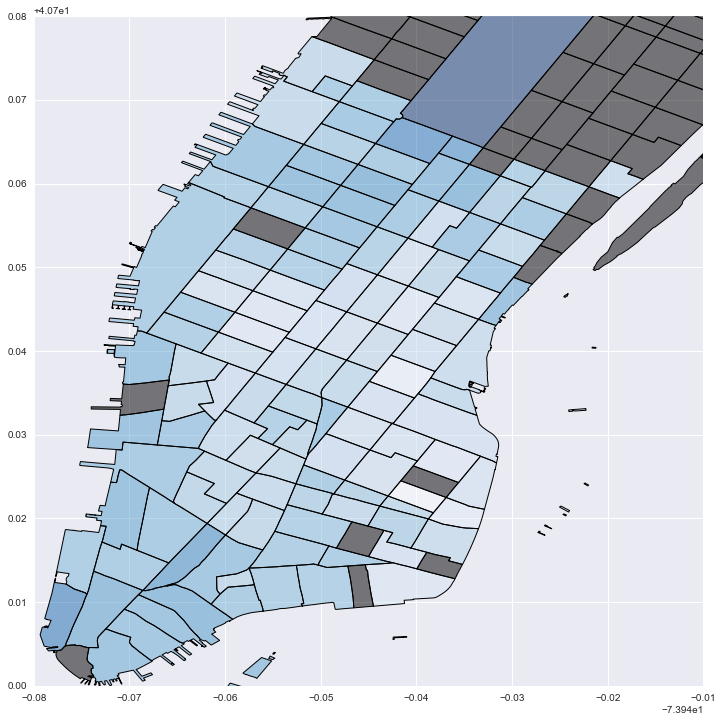

In [13]:
#Plot local "cost" values: darker blue is stronger distance decay; grey is no data

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
local_vals['inv_betas'] = (local_vals['betas']*-1)
no_tracts['test'] = 0
no_tracts.plot('test', cmap='copper', ax=ax)
local_vals.plot('inv_betas', cmap='Blues', ax=ax)
plt.xlim(-74.02, -73.95)
plt.ylim(40.7, 40.78)

//anaconda/envs/spint/lib/python2.7/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


(40.7, 40.78)

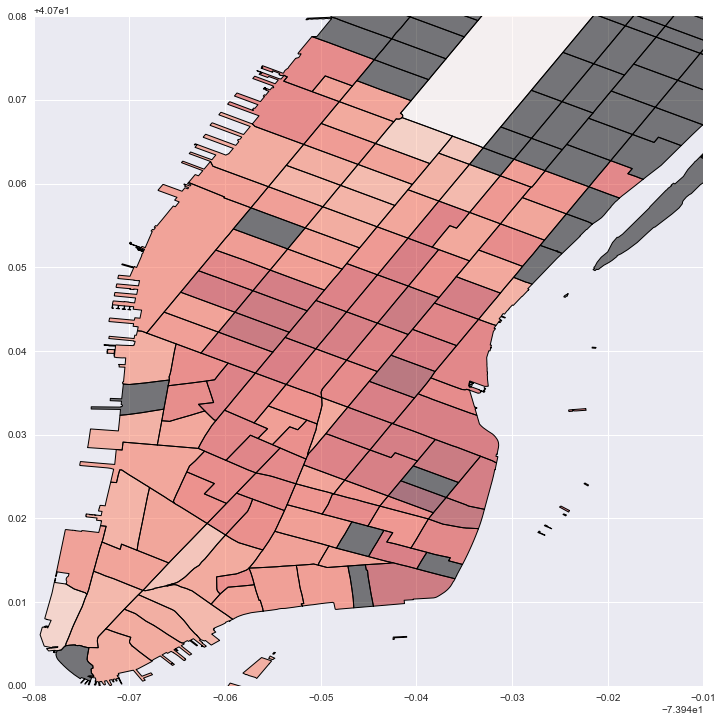

In [14]:
#Plot local estimates for destination capacity: darker red is larger effect; grey is no data

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
local_vals['cap'] = local_prod['param3']
no_tracts['test'] = 0
no_tracts.plot('test', cmap='copper', ax=ax)
local_vals.plot('cap', cmap='Reds', ax=ax)
plt.legend()
plt.xlim(-74.02, -73.95)
plt.ylim(40.7, 40.78)

(40.7, 40.78)

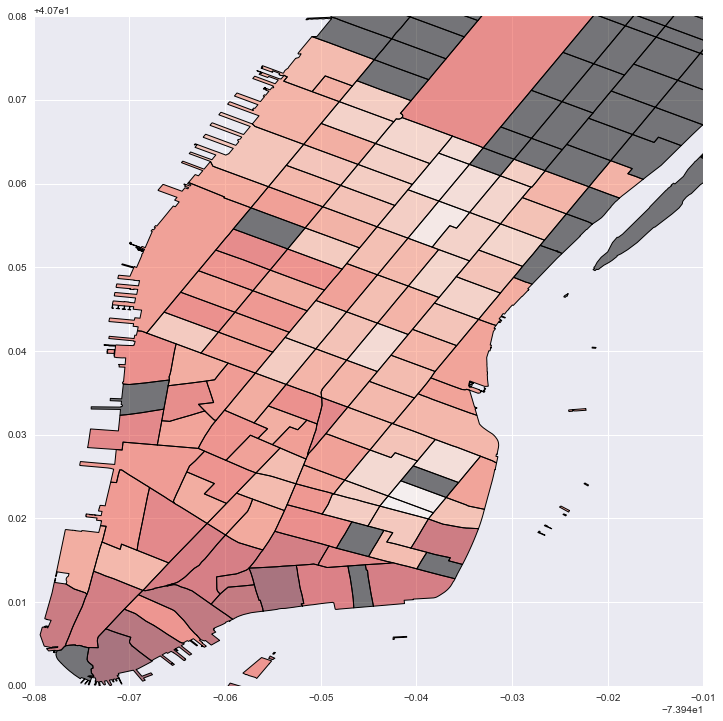

In [15]:
#Plot local estimates for # of housing units: darker red is larger effect; grey is no data

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
local_vals['house'] = local_prod['param2']
no_tracts['test'] = 0
no_tracts.plot('test', cmap='copper', ax=ax)
local_vals.plot('house', cmap='Reds', ax=ax)
plt.legend()
plt.xlim(-74.02, -73.95)
plt.ylim(40.7, 40.78)

(40.7, 40.78)

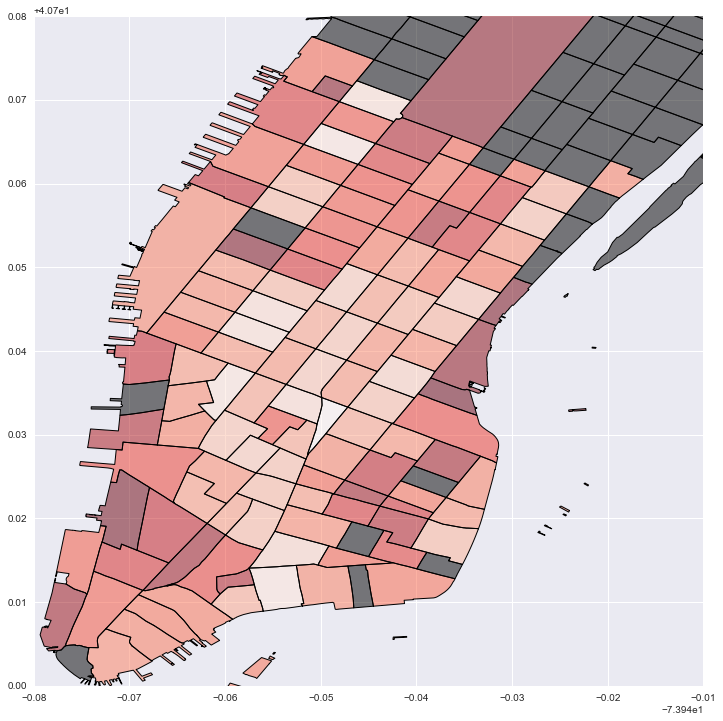

In [16]:
#Plot local estimates for destination building sq footage: darker red is larger effect; grey is no data

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
local_vals['foot'] = local_prod['param1']
no_tracts['test'] = 0
no_tracts.plot('test', cmap='copper', ax=ax)
local_vals.plot('foot', cmap='Reds', ax=ax)
plt.legend()
plt.xlim(-74.02, -73.95)
plt.ylim(40.7, 40.78)

In [17]:
#Drop NA values
labels = ['start station longitude', 'start station latitude', 'end station longitude', 'end station latitude']
bikes = bikes.dropna(subset=labels)

In [18]:
#Prep OD data as vectors and then compute origin or destination focused distance-based weights

ids = bikes['index'].reshape((-1,1))
origin_x = bikes['SX'].reshape((-1,1))
origin_y = bikes['SY'].reshape((-1,1))
dest_x = bikes['EX'].reshape((-1,1))
dest_y = bikes['EY'].reshape((-1,1))


vecs = np.hstack([ids, origin_x, origin_y, dest_x, dest_y])
origins = vecs[:,1:3]
wo = ps.weights.DistanceBand(origins, 999, alpha=-1.5, binary=False, build_sp=False, silent=True)
dests = vecs[:,3:5]
wd = ps.weights.DistanceBand(dests, 999, alpha=-1.5, binary=False, build_sp=False, silent=True)


In [19]:
#Origin focused Moran's I of OD pairs as vectors in space
vmo = VecMoran(vecs, wo, permutations=1)
vmo.I

0.15734115508365823

In [20]:
#Destination focused Moran's I of OD pairs as vectors in space
vmd = VecMoran(vecs, wd, permutations=1)
vmd.I

0.21322002653342809

In [ ]:
#No substantial examples to show for spatial interaction weights
#Will add them once there is a working SAR Lag spatial interaction
#model implementation avaialble
#from pysal.weights.spintW import vecW, netW, ODW